In [1]:
from gan import Generator, Discriminator
from peak_detector7 import Features, SignalHead, DeconvHead

from hierarchical_negbin import RecordGenerator

import os
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
cols = ["#926cb6", "#93b793", "#d31d00", "#ff900d", "#fefb03", "black"]
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
MAXBINS = 400
BATCHSIZE = 32  # max size is 64

In [3]:
simulator = RecordGenerator(n_obs=(1500, 100000),
                            n_bins=(50, MAXBINS),
                            n_meanings=(1, 4),
                            noise_ratio=(0.1, 1.0),
                            noise_dispersion=(0.05, 1.5),
                            alpha_meanings=(1.0, 4.0),
                            rounding=list(range(1, 17)),
                            inner_mode_dist_tol=0.25,
                            inner_sigma_ratio=3.0,
                            max_sigma_to_bins_ratio=0.125,
                            sigmas=(1.0, 50.0),
                            trim_corners=True)

In [4]:
geninput_noise = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_signal = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
geninput_noiseratio = tf.keras.Input(shape=(1, 1), dtype=tf.float32)
disinput = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)

genoutput = Generator(ksize=7, filters=32, nblocks=16)([geninput_noise, geninput_signal, geninput_noiseratio])
disoutput = Discriminator(ksize=7, filters=32, nblocks=16)(disinput)

generator = tf.keras.Model(inputs=[geninput_noise, geninput_signal, geninput_noiseratio], outputs=genoutput)
discriminator = tf.keras.Model(inputs=disinput, outputs=disoutput)

In [5]:
# generator.load_weights("generator.h5")
# discriminator.load_weights("discriminator.h5")

In [ ]:
inputs_smoother = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
inputs_deconv = tf.keras.Input(shape=(MAXBINS, 2), dtype=tf.float32)
feats_smoother = Features(ksize=7, filters=32, nblocks=12)(inputs_smoother)
feats_deconv = Features(ksize=7, filters=32, nblocks=16)(inputs_deconv)
signal, peaks = SignalHead(ksize=5, filters=32, nblocks_signal=2, nblocks_peaks=4)([feats_smoother, inputs_smoother])
deconv = DeconvHead(ksize=5, filters=32, nblocks=4)([feats_deconv, inputs_deconv])

model_smoother = tf.keras.Model(inputs=inputs_smoother, outputs=[signal, peaks])
model_deconv = tf.keras.Model(inputs=inputs_deconv, outputs=deconv)

In [ ]:
# model_deconv.load_weights("tmp_back_to_two_deconv.h5")
# model_smoother.load_weights("tmp_back_to_two_smoother.h5")

In [8]:
def standardize_bins(obs):
    if len(obs) > MAXBINS:
        start = (len(obs) - MAXBINS) // 2
        obs = obs[start:(start + MAXBINS)]
    L = len(obs)
    assert L <= MAXBINS
    start = MAXBINS // 2 - L // 2
    end = start + L
    out = np.zeros(MAXBINS, dtype=type(obs[0]))
    out[start:end] = obs
    return out, start

    
def preprocess_input(obs):
    # assumes 1 vector of observation and possibly multiple peaks
    obs, start = standardize_bins(obs)
    x = np.array(obs, dtype=np.float32)
    x /= x.sum()
    xinput = x * np.sqrt(MAXBINS)
    xinput = np.expand_dims(xinput, -1)
    return xinput


def preprocess_batch(batch):
    # assumes 1 vector of observation and possibly multiple peaks
    x = [preprocess_input(x) for x in batch]
    x = np.stack(x)
    return x


def get_generator_input(batch):
    nbins_sizes = [len(x) for x in batch]
    noises = []
    signals = []
    for n in nbins_sizes:
        z = np.random.normal(size=n)
        z, _ = standardize_bins(z)
        dat = simulator.generate(n_bins=n)
        pdf = dat['pdf']
        pdf, _ = standardize_bins(pdf)
        noises.append(z)
        signals.append(pdf)
    noises = np.stack(noises, 0)       
    noises = np.expand_dims(noises, -1)
    signals = np.stack(signals, 0)       
    signals = np.expand_dims(signals, -1)
    nr = np.random.uniform(0.1, 0.5, size=(len(batch), 1, 1))
    return noises, signals, nr


def get_batch(file):
    with open(file, "r") as f:
        x = json.load(f)
    return x

def get_gan_inputs(batch):
    batch = [x['counts'] for x in batch]
    x = preprocess_batch(batch)
    noises, pdfs, noiseratio = get_generator_input(batch)
    return x, noises, pdfs, noiseratio

In [ ]:
def preprocess_smoother_deconv_inputs(obs, pdf, meaning_modes, meaning_pdfs):
    # assumes 1 vector of observation and possibly multiple peaks
    obs, start = standardize_bins(obs)
    meaning_modes = np.array([start + x for x in meaning_modes])
    x = np.array(obs, dtype=np.float32)
    x /= x.sum()
    xinput = x * np.sqrt(MAXBINS)
    xinput = np.expand_dims(xinput, 0)
    xinput = np.expand_dims(xinput, -1)
    #
    npeaks = len(meaning_modes)
    onehot_vecs = []
    for m in meaning_modes:
        z = np.zeros(MAXBINS, np.float32)
        z[m] = 1.0
        onehot_vecs.append(z)
    peakinput = np.stack(onehot_vecs, 0)
    peakinput = np.expand_dims(peakinput, -1)
    #
    xstack = np.stack([np.squeeze(xinput, 0)] * npeaks, 0)
    deconv_input = np.concatenate([xstack, peakinput], -1)
    #
    meaning_pdfs_out = [standardize_bins(x) for x in meaning_pdfs]
    pdf_out = [standardize_pdfs(pdf)][0]

    return x, xinput, peakinput, deconv_input, meaning_modes, meaning_pdfs_out, pdf_out, start


def tv2(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    out = tf.reduce_sum((x1 - x0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def tv_trend(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    out = tf.reduce_sum((z1 - z0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def skl(y, yhat):
    x = - 0.5 * y * tf.math.log((yhat + 1e-10) / (y + 1e-10))
    x += - 0.5 * yhat * tf.math.log((y + 1e-10) / (yhat + 1e-10))
    x = tf.math.reduce_sum(x, 1)
    loss = tf.math.reduce_mean(x)
    return loss


def my_loss_density(y, yhat):
    return tv_trend(yhat) + 2.5 * tv2(yhat) + skl(y, yhat)


def my_loss_density_extra_reg(y, yhat):
    return tv_trend(yhat) + 10.0 * tv2(yhat) + skl(y, yhat)


def my_loss_peaks(y, yhat):
    out1 = - y * tf.math.log(yhat + 1e-10)  # upsampling
    out2 = - (1.0 - y) * tf.math.log(1.0 - yhat + 1e-10)
    return  tf.reduce_mean(out1 + out2) + 0.01 * tv2(yhat)


model_smoother.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=5e-4,
                clipnorm=10.0),
              loss=[my_loss_density, my_loss_peaks])

model_deconv.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=5e-4,
                clipnorm=10.0),
              loss=my_loss_density_extra_reg)

In [ ]:
def plot_test_case():
    data = generator.generate()
    n_bins_0 = data['n_bins']
    modes_onehot, meaning_wts = data['modes_onehot'], data['meaning_wts']
    meaning_modes, meaning_wts_onehot = data['meaning_modes'], data['meaning_wts_onehot']
    obs = data['obs']
    meaning_pdfs = data['meaning_pdfs']
#     print(meaning_pdfs)
    meaning_n_obs = data['meaning_n_obs']
    meaning_n_comps = data['meaning_n_comps']
    meaning_means, meaning_sigmas = data['meaning_means'], data['meaning_sigmas']
#     n_bins = data['n_bins']
    n_bins = MAXBINS
    
    h = np.arange(n_bins)
    x, smoother_input, peakinput, deconv_input, meaning_modes, meaning_pdfs, pdf, start =\
        prepare_network_input_output(data['obs'], data['pdf'], meaning_modes, meaning_pdfs)

    modes_onehot, _ = standardize_bins(modes_onehot)
    
#     print(smoother_input.shape)
#     print(deconv_input.shape)
#     print(smoother_input[:,:,2])
#     print(deconv_input[:,:,2])

    smooth, peaks = model_smoother(smoother_input)
    deconvolved = model_deconv(deconv_input)
#     smooth, peaks = model_smoother(smoother_inputs)
    smooth = np.squeeze(smooth.numpy())
    peaks = np.squeeze(peaks.numpy())
#     deconvolved = model_deconv(deconv_input)
    deconvolved = np.squeeze(deconvolved.numpy(), -1)

    
#     print(n_bins)
#     print(deconv_input.shape)
#     print(deconvolved.shape)
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.ylim(0, 25 * np.mean(x[x > 0]))
    plt.bar(h, x, width=2, alpha=0.75, color=viridis(peaks))
    plt.plot(h + 0.5, pdf, c="black", ls="-.")
    r, nc, noise_disp = data['rounding'], data['n_meanings'], data['noise_dispersion']
    N, eps, sig_disp = data['n_bins'], data['noise_ratio'], data['signal_overdispersion']

    print(list(zip(meaning_modes.astype(int), np.round(meaning_wts, 3), meaning_n_obs)))
    
    meaning_means = [[int(xi) for xi in np.round(x)] for x in meaning_means]
    meaning_sigmas = [[int(xi) for xi in np.round(x)] for x in meaning_sigmas]
    print(f"meaning_means: {meaning_means}, meaning_sigmas: {meaning_sigmas}")
    plt.title(f"round: {r}, n_comps: {meaning_n_comps}, n_meanings: {nc}, noise_disp: {noise_disp:.2f},\
        noise: {eps:.2f}, sig_disp: {sig_disp:.2f}, nbins: {N}")
    for w, d, m, c in zip(meaning_wts, meaning_pdfs, meaning_modes, cols):
#         plt.plot(h, w * d, c=c)
        plt.axvline(int(np.round(m)), c=c, ls="--")
    plt.plot(h + 0.5, smooth, c="red", lw=2)
    plt.show()
    # deconvolved
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.ylim(0, 25 * np.mean(x[x > 0]))
    for i in range(len(meaning_modes)):
        truth = meaning_pdfs[i]
        y = deconvolved[i,:]
        plt.plot(h + 0.5, truth, c=cols[i], ls="--")
        plt.plot(h + 0.5, y, c=cols[i])
    plt.title("meaning deconvolution")
    plt.show()
    # peaks
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.scatter(h + 0.75, peaks, c="blue", alpha=0.5)
    plt.scatter(h + 0.5, modes_onehot, c="red")
    plt.title("peak finding")
    plt.show()

        
plot_test_case()

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-5)


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(real_signal, noise, pdf, nr):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, pdf, nr], training=True)
        real_output = discriminator(real_signal, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [16]:
fdir = "../SmoothDoQ/doq_noun_batches/"
files = np.random.shuffle(os.listdir(fdir))
files = [os.path.join(fdir, x) for x in files]

In [17]:
gen_loss_ = 0.0
disc_loss_ = 0.0

===== Epoch 1: =====
iter: 0, completed: 0.00%, gen_loss: 1.344, disc_loss: 0.511


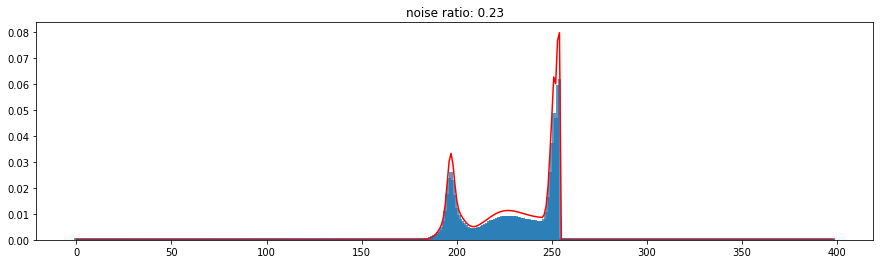

KeyboardInterrupt: 

In [20]:
print_every = 10
plot_every = 10
save_every = 50
lam = 0.01
epochs = 10
entries_per_file = 64
batches_per_file = entries_per_file // BATCHSIZE

for epoch in range(epochs):
    print("===== Epoch 1: =====")
    i = 0
    for file in files:
        file_data = get_batch(file)
        for b in range(batches_per_file):
            batch = file_data[b*BATCHSIZE:(b + 1)*BATCHSIZE]
            x, z, s, nr = get_gan_inputs(batch)
            x_ = tf.constant(x, tf.float32)
            z_ = tf.constant(z, tf.float32)
            s_ = tf.constant(s, tf.float32)
            nr_ = tf.constant(nr, tf.float32)
            gen_loss, disc_loss = train_step(x_, z_, s_, nr_)

            # record losses
            if i > 0:
                gen_loss_ += lam * (gen_loss.numpy() - gen_loss_)
                disc_loss_ += lam * (disc_loss.numpy() - disc_loss_)
            else:
                gen_loss_ = gen_loss.numpy()
                disc_loss_ = disc_loss.numpy()
                
            # print
            if i % print_every == 0:
                fr = f"iter: {i}, completed: {(i + 1) / len(files):.2f}%"
                msg = f"{fr}, gen_loss: {gen_loss_:.3f}, disc_loss: {disc_loss_:.3f}"
                print(msg)

            if i % plot_every == 0:
                x0 = np.expand_dims(x[0, :, :], 0).astype(np.float32)
                z0 = np.expand_dims(z[0, :, :], 0).astype(np.float32)
                s0 = np.expand_dims(s[0, :, :], 0).astype(np.float32)
                nr0 = np.expand_dims(nr[0, :, :], 0).astype(np.float32)
                pdf = np.squeeze(s0)            
                fake = generator([z0, s0, nr0])
                fake = np.squeeze(fake.numpy())
                in_range = np.where(fake > 0.0)[0]
                h = range(in_range[0], in_range[-1])    
                plt.figure(figsize=(15, 4))
                plt.bar(h, fake[h], width=2, alpha=0.75)
                plt.plot(h, pdf[h], c="red")
                plt.title(f"noise ratio: {nr0[0,0,0]:.2f}")
                plt.show()

            # Save the model every 15 epochs
            if i % save_every == 0:
                generator.save_weights("generator.h5")
                discriminator.save_weights("discriminator.h5")
                
            i += 1